In [1]:
from pathlib import Path
import time
import torch
import numpy as np
from dataset import LinearDynamicalDataset
from torch.utils.data import DataLoader
from model_ts import GPTConfig, GPT
import tqdm
import argparse

In [2]:
# Overall settings
out_dir = "out"

# System settings
nx = 10
nu = 1
ny = 1
seq_len = 500

# Transformer settings
block_size = seq_len
n_layer = 8
n_head = 4
n_embd = 128
dropout = 0.0
bias = False


# Compute settings
cuda_device = "cuda:0"
no_cuda = True
threads = 5
compile = True

# Create out dir
out_dir = Path(out_dir)

# Configure compute
torch.set_num_threads(threads)
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

# Create data loader
test_ds = LinearDynamicalDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len)
test_dl = DataLoader(test_ds, batch_size=256, num_workers=threads)

model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, n_y=1, n_u=1, block_size=block_size,
                  bias=bias, dropout=dropout)  # start with model_args from command line
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)

exp_data = torch.load(out_dir/"ckpt.pt")
state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 1.64M


In [3]:
batch_y, batch_u = next(iter(test_dl))
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)
    batch_y_pred = batch_y_pred.detach().numpy()
    batch_y = batch_y.detach().numpy()
    batch_u = batch_u.detach().numpy()

In [4]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

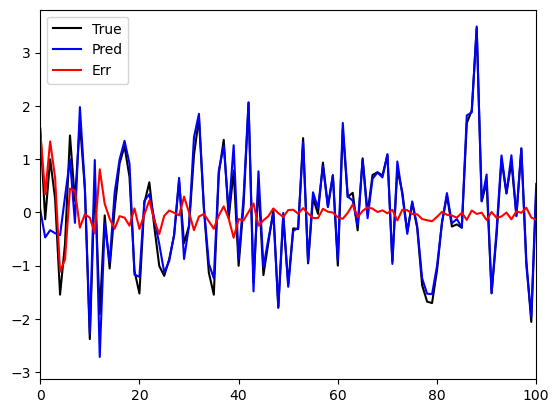

In [5]:
import matplotlib.pyplot as plt
idx = 4
plt.plot(batch_y_target[idx], 'k', label="True")
plt.plot(batch_y_pred[idx], 'b', label="Pred")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(batch_y_target[idx] - batch_y_pred[idx], 'r', label="Err")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
plt.legend()
plt.xlim([0, 100]);

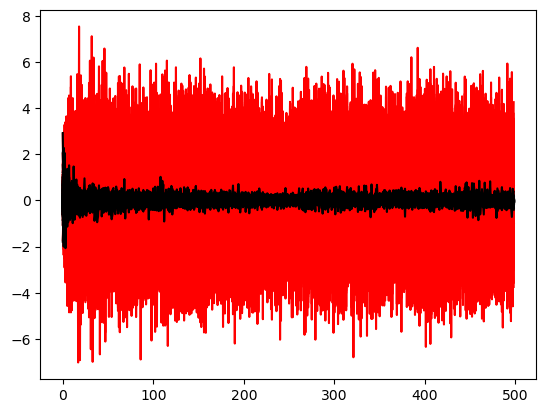

In [6]:
plt.plot(batch_pred_err_dummy.squeeze(-1).T, "r");
plt.plot(batch_pred_err.squeeze(-1).T, "k");

In [7]:
from torchid import metrics
skip = 50
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

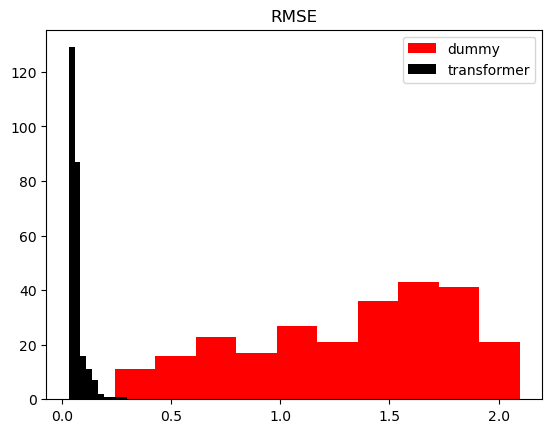

In [8]:
plt.figure()
plt.title("RMSE")
plt.hist(rmse_dummy, color="red", label="dummy");
plt.hist(rmse_transformer, color="black", label="transformer");
plt.legend();